https://www.kaggle.com/sanjana08/hotel-booking-cancellation-prediction/data

In [20]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest,mutual_info_classif,f_classif
import seaborn as sns
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import binarize
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from datetime import datetime

In [2]:
hotel=pd.read_csv('hotel_bookings.csv')

In [3]:
# There are many NaN value in the dataset, so here I list out the count of missing values according to each columns.
hotel.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [4]:
'''Since there are many missing values in country, agent and company, I will take out the columns instead of drop the data.
    Also, I will drop out reservation_status and reservation_status_date as it shouldn't be in the process for model to learn.''' 
hotel=hotel.drop(['country','agent','company','reservation_status','reservation_status_date'],axis=1)

## Explore data

In [5]:
hotel.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


### Numerical features

In [6]:
# I identified each variables as either numerical variables or categorical variables to help further exploring data.
numerical_variables=['is_canceled','lead_time','stays_in_weekend_nights','stays_in_week_nights','adults','children','babies',
         'booking_changes','days_in_waiting_list','adr', 'required_car_parking_spaces', 
         'total_of_special_requests']

#Identifying outliers and drop them
Q1 = hotel[numerical_variables].quantile(0.25)
Q3 = hotel[numerical_variables].quantile(0.75)
IQR = Q3 - Q1

hotel_NoOutlier = hotel[~((hotel[numerical_variables] < (Q1 - 1.5 * IQR)) |(hotel[numerical_variables] > (Q3 + 1.5 * IQR))).any(axis=1)]
hotel_WithOutlier=hotel
hotel.describe()
# We can see that dropping out outliers cut down the dataset in half. Since it's still the more data, the better, 
# I will train my models on both data with or without outliers.

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


#### keep the outliers

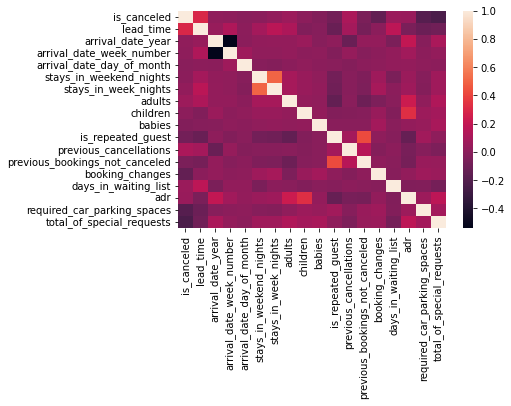

In [7]:
ax = sns.heatmap(hotel_WithOutlier.corr())

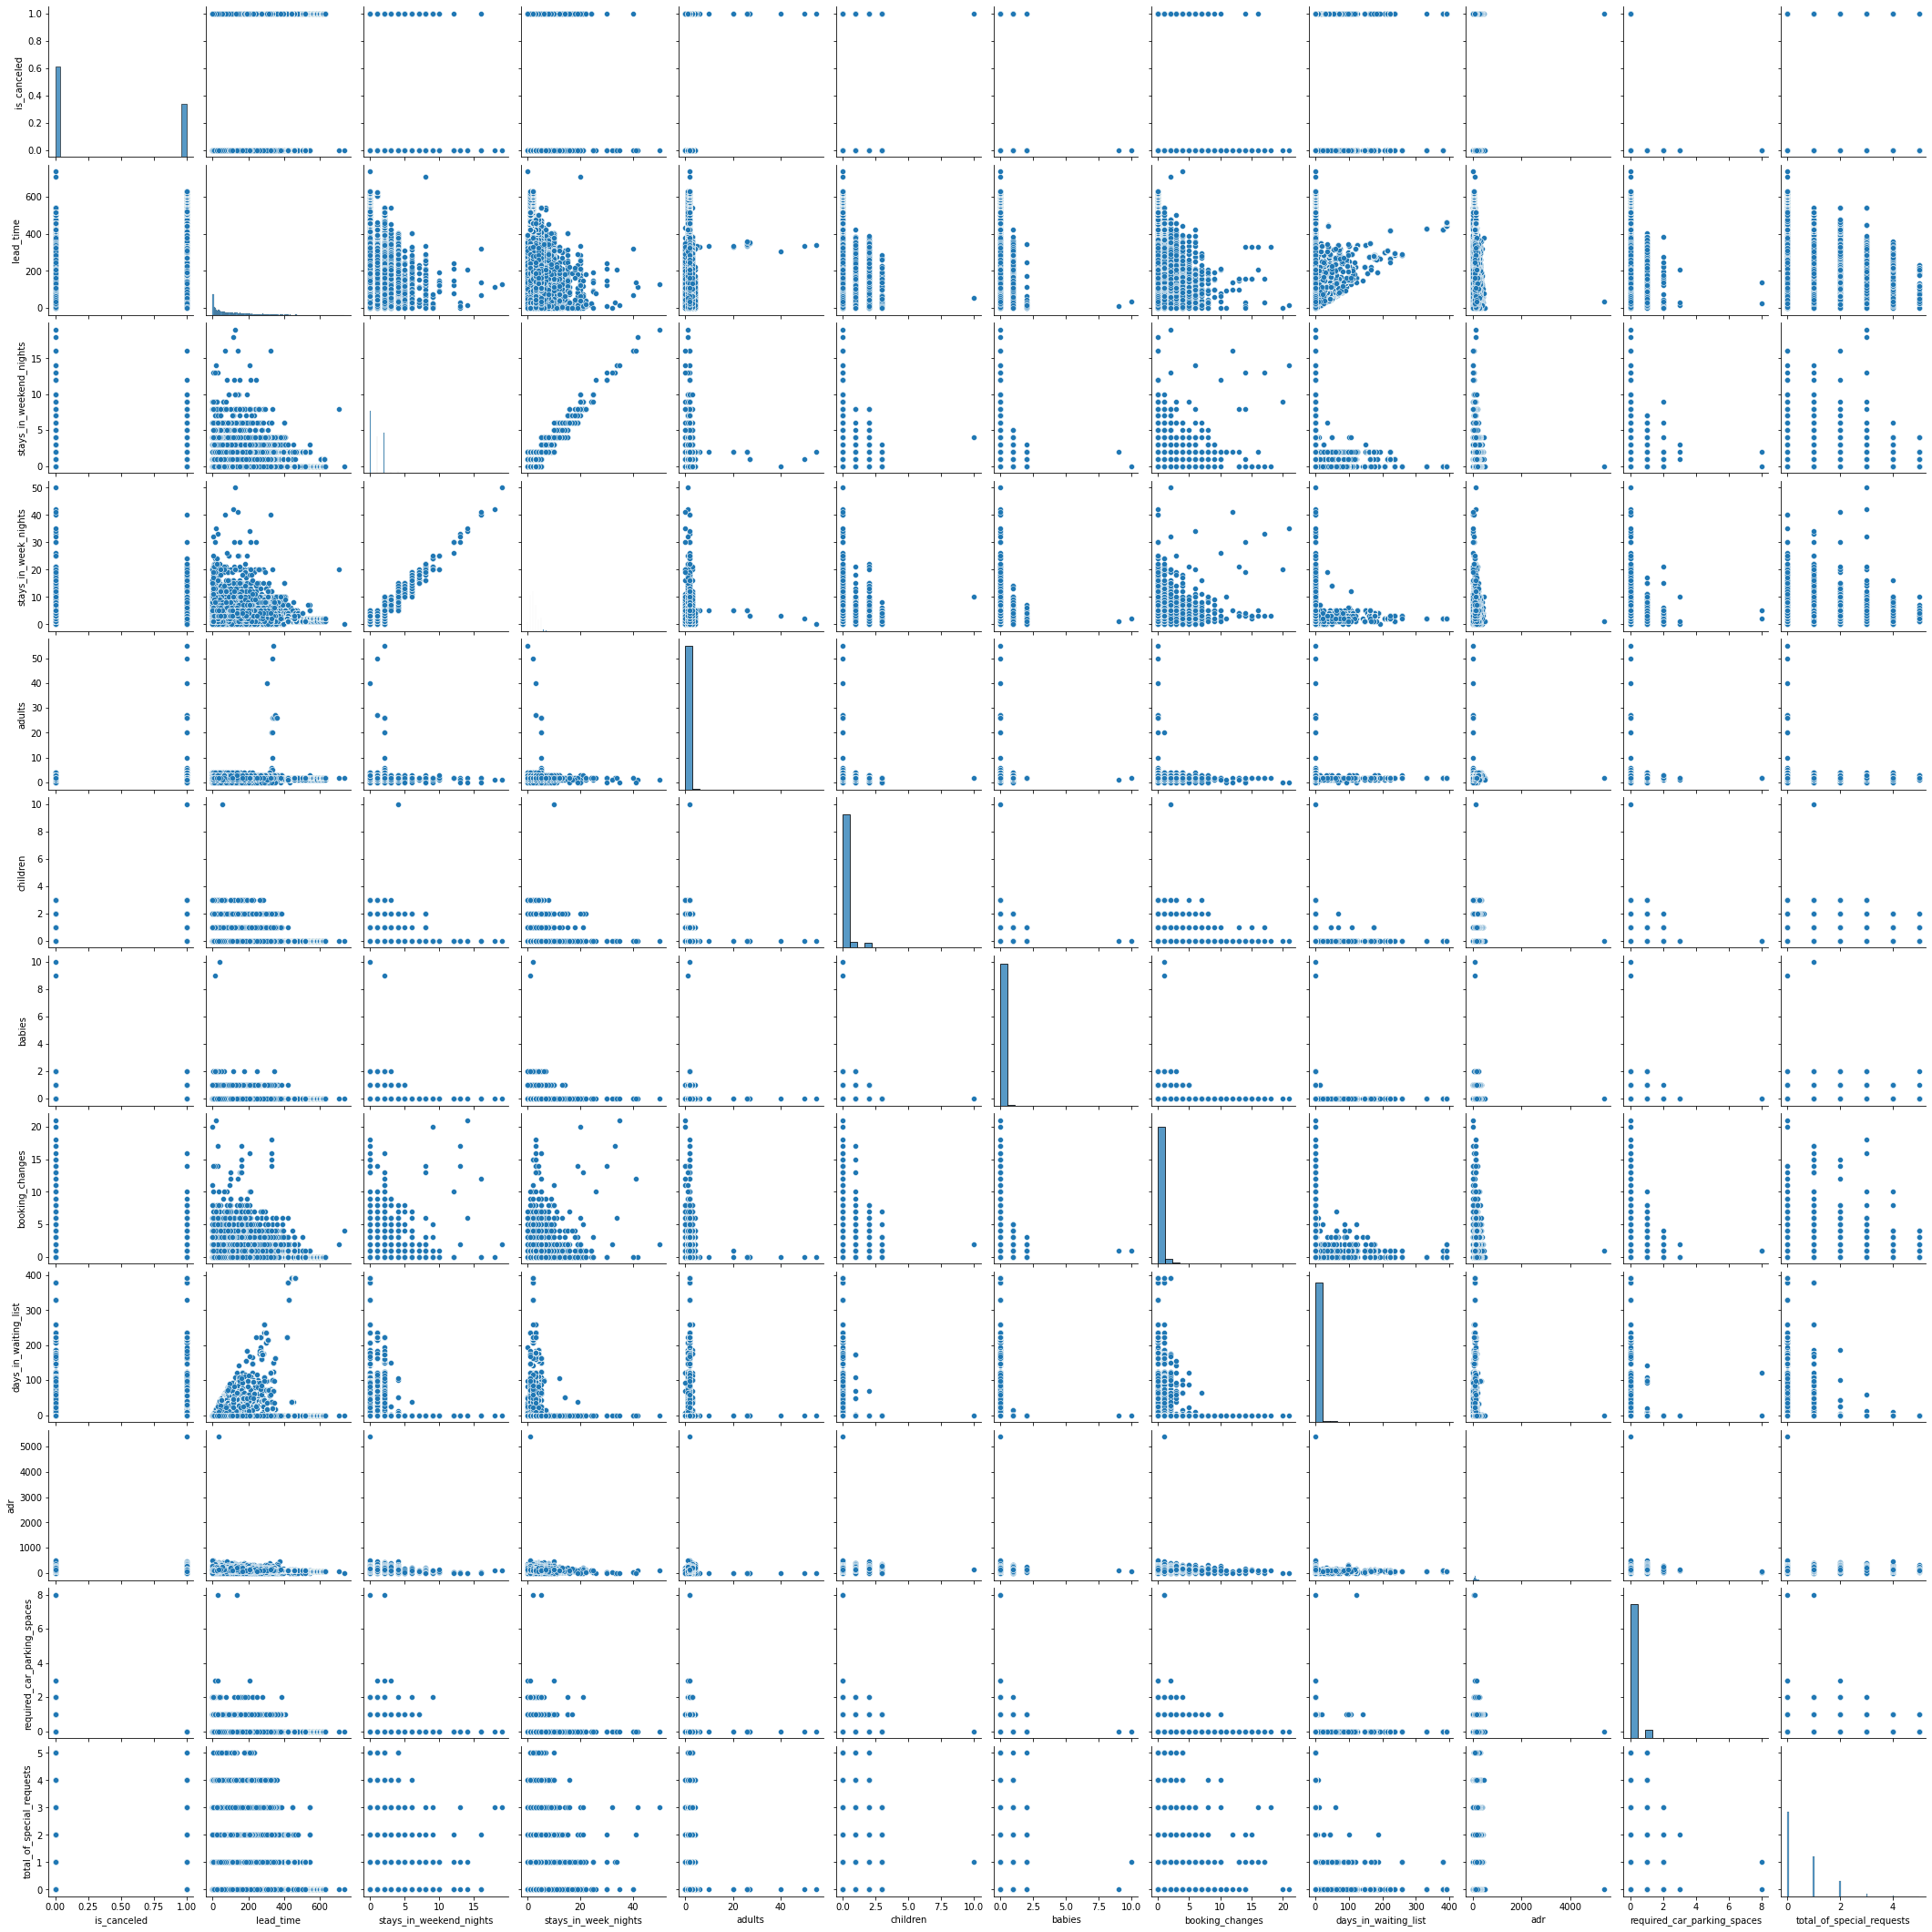

In [8]:
sns.pairplot(hotel_WithOutlier[numerical_variables])

In [9]:
# kendalltau correlation is able to model non linear relationship, so here I also print out the correlation score. 
# From the scores,I will only take features which are significant.
tau_list=[]
p_value_list=[]
for i in numerical_variables:
    tau, p_value = stats.kendalltau(hotel_WithOutlier[i], hotel_WithOutlier['is_canceled'])
    tau_list.append(tau)
    p_value_list.append(p_value)

non_linear_correlation=pd.DataFrame({'tau': tau_list,
                                    'p-value': p_value_list}).transpose()
non_linear_correlation.columns=numerical_variables
non_linear_correlation

C:\Users\jojoh\anaconda3\envs\CIS508\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
tau,1.0,0.259528,-0.003850,3.687244e-02,6.560449e-02,NaN,-3.430408e-02,-0.181956,9.749188e-02,4.165589e-02,-0.19737,-0.247219
p-value,0.0,0.000000,0.156024,1.867555e-46,1.156003e-118,NaN,1.877333e-32,0.000000,1.261032e-252,3.567325e-69,0.00000,0.000000


#### take out outliers

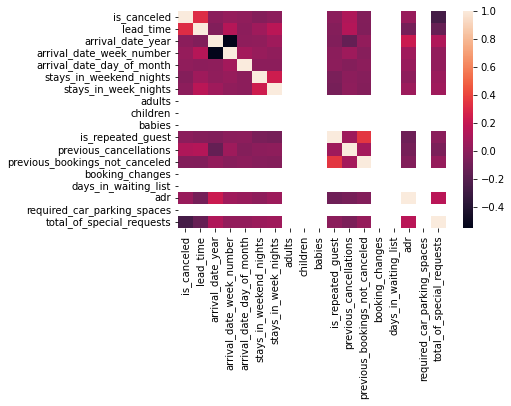

In [10]:
ax = sns.heatmap(hotel_NoOutlier.corr())

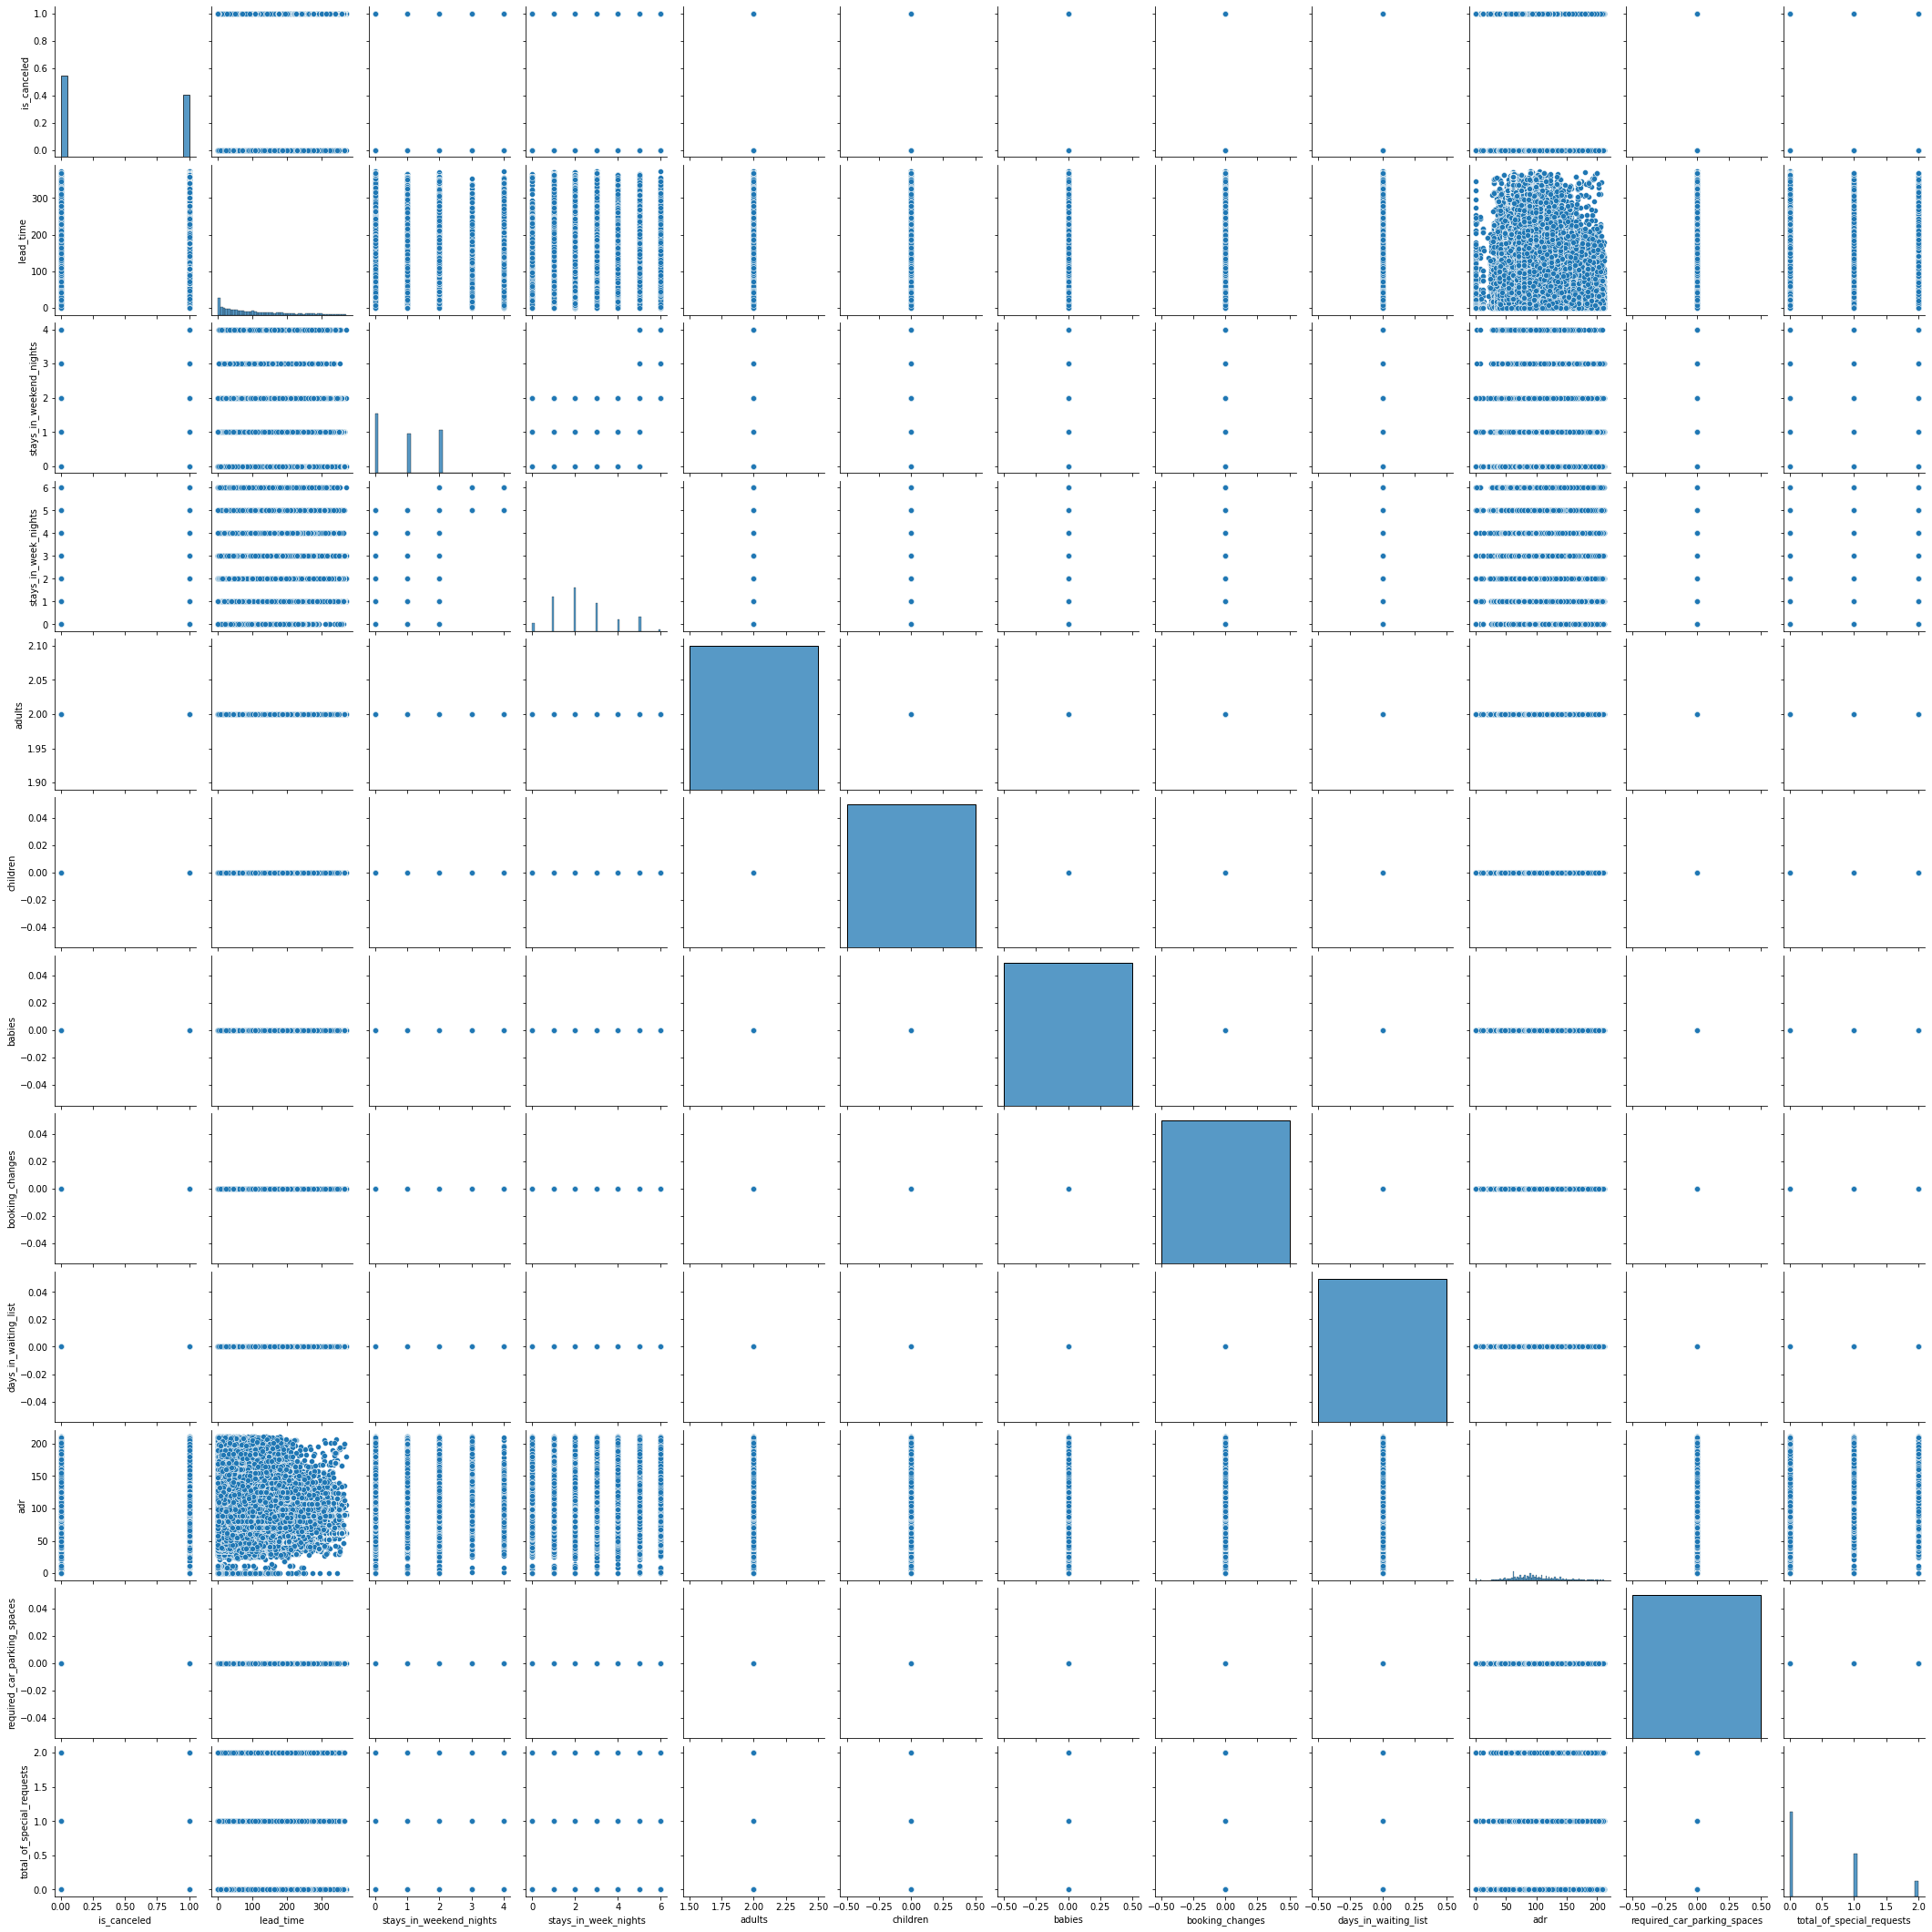

In [11]:
sns.pairplot(hotel_NoOutlier[numerical_variables])

In [12]:
# kendalltau correlation is able to model non linear relationship, so here I also print out the correlation score. 
# From the scores,I will only take features which are significant.
tau_list=[]
p_value_list=[]
for i in numerical_variables:
    tau, p_value = stats.kendalltau(hotel_NoOutlier[i], hotel_NoOutlier['is_canceled'])
    tau_list.append(tau)
    p_value_list.append(p_value)

non_linear_correlation=pd.DataFrame({'tau': tau_list,
                                    'p-value': p_value_list}).transpose()
non_linear_correlation.columns=numerical_variables
non_linear_correlation

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
tau,1.0,0.25973,-3.211785e-02,0.00442,NaN,NaN,NaN,NaN,NaN,2.351788e-02,NaN,-0.28012
p-value,0.0,0.00000,7.135947e-17,0.22691,NaN,NaN,NaN,NaN,NaN,2.149852e-12,NaN,0.00000


### Categorical features

In [13]:
# For categorical variables, I will confuct 3 kinds of feature selection methods to 
# identify features contribute most to the target variables. For each method I will select 10, 12, 15 features at a time.
categorical_variables=['hotel','arrival_date_year','arrival_date_month', 'arrival_date_week_number',
        'arrival_date_day_of_month','meal', 'market_segment','distribution_channel','is_repeated_guest',
        'previous_cancellations','previous_bookings_not_canceled','reserved_room_type',
        'assigned_room_type','deposit_type','customer_type']

# Using OneHot encoding will result in lots of additional columns. Thus I chose to encode my categorical features using LabelEncoder
le = LabelEncoder()
hotel_cat=hotel[categorical_variables].apply(LabelEncoder().fit_transform)


chi_select_feature_10 = SelectKBest(chi2, k=10).fit(hotel_cat, hotel['is_canceled'])
chi_select_feature_12 = SelectKBest(chi2, k=12).fit(hotel_cat, hotel['is_canceled'])
chi_select_feature_15 = SelectKBest(chi2, k=15).fit(hotel_cat, hotel['is_canceled'])


f_select_features_10 = SelectKBest(f_classif, k=10).fit(hotel_cat, hotel['is_canceled'])
f_select_features_12 = SelectKBest(f_classif, k=12).fit(hotel_cat, hotel['is_canceled'])
f_select_features_15 = SelectKBest(f_classif, k=15).fit(hotel_cat, hotel['is_canceled'])


mi_select_features_10 = SelectKBest(mutual_info_classif, k=10).fit(hotel_cat, hotel['is_canceled'])
mi_select_features_12 = SelectKBest(mutual_info_classif, k=12).fit(hotel_cat, hotel['is_canceled'])
mi_select_features_15 = SelectKBest(mutual_info_classif, k=15).fit(hotel_cat, hotel['is_canceled'])

## Model

In [23]:
# models functions
# I didn't do the probability threshold determination since the optimal threshold for each classifier might be different and 
# that will make it hard to compare between models.

def LR(X_train, X_test, y_train, y_test):
    start_time = datetime.now()
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    end_time = datetime.now()
    accuracy=accuracy_score(y_test, y_pred)
    print("lr accuracy: ",accuracy)
    print('Duration: {}'.format(end_time - start_time))
    return accuracy

def kNN(X_train, X_test, y_train, y_test):
    k = chooseK(X_train, X_test, y_train, y_test)
    start_time = datetime.now()
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    end_time = datetime.now()
    accuracy=accuracy_score(y_test, y_pred)
    print("knn accuracy: ",accuracy)
    print('Duration: {}'.format(end_time - start_time))
    return accuracy

def DT(X_train, X_test, y_train, y_test):
    start_time = datetime.now() 
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    end_time = datetime.now()
    accuracy = accuracy_score(y_test,y_pred)
    print("dt accuracy: ",accuracy)
    print('Duration: {}'.format(end_time - start_time))
    return accuracy

def RF(X_train, X_test, y_train, y_test):
    start_time = datetime.now()
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    end_time = datetime.now()
    accuracy = accuracy_score(y_test,y_pred)
    print("rf accuracy: ",accuracy)
    print('Duration: {}'.format(end_time - start_time))
    return accuracy

def MLP(X_train, X_test, y_train, y_test):
    start_time = datetime.now()
    clf = MLPClassifier(random_state=1, max_iter=300)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    end_time = datetime.now()
    accuracy = accuracy_score(y_test,y_pred)
    print("mlp accuracy: ",accuracy)
    print('Duration: {}'.format(end_time - start_time))
    return accuracy

In [24]:
def chooseK(X_train, X_test, y_train, y_test):
    Accuracy = []
    k_list = [1,3,5,7,9,11]
    for k in k_list:
        knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracy_value = accuracy_score(y_test, y_pred).round(2)
        Accuracy.append(accuracy_value)
    max_index =  Accuracy.index(max(Accuracy))
    return k_list[max_index]

In [25]:
# train models without outliers in the dataset and with combinations of each feature selection methods

lr=[]
knn=[]
dt=[]
rf=[]
mlp=[]

feature_selection_methods=[chi_select_feature_10,chi_select_feature_12,chi_select_feature_15,
                           f_select_features_10,f_select_features_12,f_select_features_15,
                          mi_select_features_10,mi_select_features_12,mi_select_features_15]

for i in feature_selection_methods:
    print(i)
    selected_feature_names=hotel_cat.columns[i.get_support()]
    #combine selected continuous variables and categorical variables
    numerical=hotel_NoOutlier[['lead_time','stays_in_weekend_nights','adr','total_of_special_requests']]
    categorical=hotel_NoOutlier[selected_feature_names].apply(LabelEncoder().fit_transform)
    hotel_selected=pd.concat([numerical,categorical], axis=1)
    
    X=hotel_selected
    Y=hotel_NoOutlier['is_canceled']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    # Normalize Data
    X_train_means = X_train.mean()
    X_train_std = X_train.std()

    # Please note that I am using means and standard deviations from the training
    # data to normalize BOTH the training and the test data.
    X_train = (X_train - X_train_means)/X_train_std
    X_test = (X_test - X_train_means)/X_train_std
    
    
    lr.append(LR(X_train, X_test, y_train, y_test))
    knn.append(kNN(X_train, X_test, y_train, y_test))
    dt.append(DT(X_train, X_test, y_train, y_test))
    rf.append(RF(X_train, X_test, y_train, y_test))
    mlp.append(MLP(X_train, X_test, y_train, y_test))

summary = pd.DataFrame(np.column_stack([lr,knn,dt,rf,mlp]), 
                        columns=['LR','KNN','DT','RF','MLP'])

SelectKBest(score_func=<function chi2 at 0x000002314B671CA0>)
lr accuracy:  0.7728815445390308
Duration: 0:00:00.283269
knn accuracy:  0.8055416458020364
Duration: 0:00:08.853778
dt accuracy:  0.7926890335503255
Duration: 0:00:00.109379
rf accuracy:  0.7364936293328882
Duration: 0:00:00.676517
mlp accuracy:  0.8019807489011295
Duration: 0:01:09.604649
SelectKBest(k=12, score_func=<function chi2 at 0x000002314B671CA0>)
lr accuracy:  0.7727702665108774
Duration: 0:00:00.109550
knn accuracy:  0.8063205919991098
Duration: 0:00:12.197540
dt accuracy:  0.8082679574917933
Duration: 0:00:00.140596
rf accuracy:  0.7351026539809714
Duration: 0:00:00.764105
mlp accuracy:  0.805597284816113
Duration: 0:01:27.899315
SelectKBest(k=15, score_func=<function chi2 at 0x000002314B671CA0>)
lr accuracy:  0.7741056028487175
Duration: 0:00:00.130678
knn accuracy:  0.7981416569298392
Duration: 0:00:09.935530
dt accuracy:  0.7991431591832193
Duration: 0:00:00.171825
rf accuracy:  0.7366049073610416
Duration: 0

In [26]:
summary=summary.T
summary.columns=['chi_select_feature_10','chi_select_feature_12','chi_select_feature_15',
                           'f_select_features_10','f_select_features_12','f_select_features_15',
                          'mi_select_features_10','mi_select_features_12','mi_select_features_15']
summary

,chi_select_feature_10,chi_select_feature_12,chi_select_feature_15,f_select_features_10,f_select_features_12,f_select_features_15,mi_select_features_10,mi_select_features_12,mi_select_features_15
LR,0.772882,0.772770,0.774106,0.772882,0.775163,0.774106,0.773271,0.770044,0.774106
KNN,0.805542,0.806321,0.798142,0.805542,0.809659,0.798142,0.805152,0.795415,0.798142
DT,0.792689,0.808268,0.799143,0.792689,0.802927,0.799143,0.795248,0.801536,0.799143
RF,0.736494,0.735103,0.736605,0.736494,0.735103,0.736605,0.736716,0.736494,0.736605
MLP,0.801981,0.805597,0.815891,0.801981,0.809047,0.815891,0.809158,0.808991,0.815891


In [ ]:
# train models with outliers in the dataset and with combinations of each feature selection methods
lr=[]
knn=[]
dt=[]
rf=[]
mlp=[]

feature_selection_methods=[chi_select_feature_10,chi_select_feature_12,chi_select_feature_15,
                           f_select_features_10,f_select_features_12,f_select_features_15,
                          mi_select_features_10,mi_select_features_12,mi_select_features_15]
for i in feature_selection_methods:
    print(i)
    selected_feature_names=hotel_cat.columns[i.get_support()]
    #combine selected continuous variables and categorical variables
    numerical=hotel_WithOutlier[['stays_in_week_nights','adults','babies','booking_changes','days_in_waiting_list','adr','required_car_parking_spaces','total_of_special_requests']]
    categorical=hotel_WithOutlier[selected_feature_names].apply(LabelEncoder().fit_transform)
    hotel_selected=pd.concat([numerical,categorical], axis=1)
    
    X=hotel_selected
    Y=hotel_WithOutlier['is_canceled']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    # Normalize Data
    X_train_means = X_train.mean()
    X_train_std = X_train.std()

    # Please note that I am using means and standard deviations from the training
    # data to normalize BOTH the training and the test data.
    X_train = (X_train - X_train_means)/X_train_std
    X_test = (X_test - X_train_means)/X_train_std
    
    
    lr.append(LR(X_train, X_test, y_train, y_test))
    knn.append(kNN(X_train, X_test, y_train, y_test))
    dt.append(DT(X_train, X_test, y_train, y_test))
    rf.append(RF(X_train, X_test, y_train, y_test))
    mlp.append(MLP(X_train, X_test, y_train, y_test))

summary = pd.DataFrame(np.column_stack([lr,knn,dt,rf,mlp]), 
                        columns=['LR','KNN','DT','RF','MLP'])

In [ ]:
summary=summary.T
summary.columns=['chi_select_feature_10','chi_select_feature_12','chi_select_feature_15',
                           'f_select_features_10','f_select_features_12','f_select_features_15',
                          'mi_select_features_10','mi_select_features_12','mi_select_features_15']
summary

In [ ]:
# From the results above, I found that KNN, decision tree and MLP has the highest accuracy at around 82% 
# with all categorical variables selected on the dataset that keeps the outliers. 
# Thus, I will perform 5-fold cross-validation and play around the parameters on these models to make the final suggestion.
    
selected_feature_names=hotel_cat.columns[chi_select_feature_15.get_support()]
#combine selected continuous variables and categorical variables
numerical=hotel_WithOutlier[['stays_in_week_nights','adults','babies','booking_changes','days_in_waiting_list','adr','required_car_parking_spaces','total_of_special_requests']]
categorical=hotel_WithOutlier[selected_feature_names].apply(LabelEncoder().fit_transform)
hotel_selected=pd.concat([numerical,categorical], axis=1)

X=hotel_selected
Y=hotel_WithOutlier['is_canceled']

# Normalize Data
X_means = X.mean()
X_std = X.std()
X = (X - X_means)/X_std

In [ ]:
DecisionTree=DecisionTreeClassifier(random_state=0)
DT_scores = cross_val_score(DecisionTree, X, Y, cv=5)
print("DT: ",DT_scores)

In [ ]:
for i in [1,3,5,7,9]:
    pritn("i: ",i)
    kNN =KNeighborsClassifier(n_neighbors=i)
    knn_scores = cross_val_score(kNN, X, Y, cv=5)
    print("KNN: ",knn_scores)

In [ ]:
for iter in [100,300,500]:
    MLPclf = MLPClassifier(random_state=1, max_iter=iter,learning_rate='adaptive')
    MLPclf_scores = cross_val_score(MLPclf, X, Y, cv=5)
    print("MLP: ",MLPclf_scores)

I didn't keep all the outputs because I tried to rerun earlier and it cleared out some of the results. From results I've seen earlier, cross_val_score is not really good with almost every fold ending up at below 65%. One possible reason is that I kept the outliers. Yet the result is bad in every fold. I don't believe outliers are everywhere since it worked pretty good when I wasn't doing k-fold validation. This is where I still find confusing but hasn't came up with a conclusion.
Overall, KNN, DecisionTree and MLP achieves the best accuracy when I only take ['stays_in_week_nights','adults','babies','booking_changes','days_in_waiting_list','adr','required_car_parking_spaces','total_of_special_requests'] as my numerical variables and all of the categorical variables. Accuracy of decision tree is a bit lower but it is a lot faster than the other two. In the perspective of cost-saving, I would recommend to compromise with a little bit accuracy to save lots of time. Also, it is possible for NN to be a lot quicker if utilizing GPU. That might be another point to consider about since it also costs for a good GPU.